# **Gradient Checking**

---

In [ ]:
# Getting python's version

import sys

print(sys.version)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [ ]:
# Importing numpy package
import numpy as np

print(np.__version__)

1.18.5


## **Table of Contents**



1. Initialize parameters
2. Activation functions (Sigmoid, RELU)
3. Gradients of activation functions (Sigmoid, RELU)
4. Forward Propagation
5. Computing cost
6. Backpropagation
7. Update parameters
8. Regularization Changes
9. Dropout Changes
10. Gradient Checking
11. Neural Network Model
12. Predict classes function
13. Predict accuracy
14. Testing



---

*** Neural Network Structure ***

    layers     : input - [L-1] hidden - output
    activations:         [L-1] Relu   - sigmoid

    cost function: 
        logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
        cost = 1./m * np.nansum(logprobs)

## **Initialize parameters**

    * Some of the different ways for parameters initialization *

      1. Zeros
      2. Random
      3. He initialization
      4. Xavier initialization

In [ ]:
# *** Different methods of initializing parameters ***

# Zeros initialization
def initialize_parameters_zeros(layers_dims):
    parameters = {}
    L = len(layers_dims) # number of layers

    for l in range(1, L):
        parameters[f'W{l}'] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))

    return parameters


# Random initialization
def initialize_parameters_random(layers_dims, init_const=0.01, seed=None):
    if seed:
        np.random.seed(seed)

    parameters = {}
    L = len(layers_dims) # number of layers

    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l], layers_dims[l-1]) * init_const
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))

    return parameters


# He initialization
def initialize_parameters_he(layers_dims, seed=None):
    # Use when you're using `RELU` as activation function
    if seed:
        np.random.seed(seed)

    parameters = {}
    L = len(layers_dims) # number of layers
    
    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1]) 
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))
    
    return parameters


# Xavier initialization
def initialize_parameters_xavier(layers_dims, seed=None):
    # Use when you're using `tanh` as activation function

    if seed:
        np.random.seed(seed)

    parameters = {}
    L = len(layers_dims) # number of layers
    
    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(1/layers_dims[l-1]) 
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))
    
    return parameters

# *** # Different methods of initializing parameters ***


# Initialize parameters
def initialize_parameters(layers_dims, initialization='random', init_const=0.01, seed=None):
    if initialization == 'random':
        return initialize_parameters_random(layers_dims, init_const, seed)
    elif initialization == 'he':
        return initialize_parameters_he(layers_dims, seed)
    elif initialization == 'xavier':
        return initialize_parameters_xavier(layers_dims, seed)
    elif initialization == 'zeros':
        return initialize_parameters_zeros(layers_dims)

## **Activation functions**

In [ ]:
# Sigmoid function
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    cache = Z
    return A, cache

# Relu
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

## **Gradients of activation functions**

In [ ]:
""" 
    Used in backpropagation 

    dA -- post-activation gradient, of any shape
    dZ -- Gradient of the cost with respect to Z
"""

# Sigmoid
def sigmoid_backward(dA, cache):
    Z = cache
    S = 1/(1 + np.exp(-Z))
    dZ = dA * S * (1 - S)
    return dZ

# Relu
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

## **Forward Propagation**

In [ ]:
"""
    Forward propagation structure:
        input layer -> [Linear -> Relu] * (L - 1) -> [Linear -> Sigmoid] (output layer)

    One unit does two work first calculate Z (linear forward) and then calculate A (activation)
"""


# linear forward
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache


# Combining linear forward and activation steps
def linear_activation_forward(A_prev, W, b, activation):
    # Linear forward step
    Z, linear_cache = linear_forward(A_prev, W, b)

    # Forward activation step
    if activation == 'relu':
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)

    cache = (linear_cache, activation_cache)
    return A, cache


# Forward propagation for L layers
def forward_propagation(X, parameters, num_of_layers):
    caches = []
    A = X
    L = num_of_layers

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters[f'W{l}'], parameters[f'b{l}'], 'relu')
        caches.append(cache)

    # Implement LINEAR -> SIGMOID for ouput layer. Add "cache" to the "caches" list
    AL, cache = linear_activation_forward(A, parameters[f'W{L}'], parameters[f'b{L}'], 'sigmoid')
    caches.append(cache)

    return AL, caches

## **Compute cost**

In [ ]:
def compute_cost(AL, Y):
    m = Y.shape[1] # number of examples

    logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    cost = 1./m * np.nansum(logprobs)

    cost = np.squeeze(cost) # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    return cost

## **Backpropagation**

In [ ]:
"""
    Backward propagation structure
        input layer -> [Linear -> Relu] * (L - 1) -> [Linear -> Sigmoid] (output layer)

    One unit does two work first calculate Z (linear forward) and then calculate A (activation)
"""


# Linear backward step
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1] # number of examples

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


# Combining linear backward and activation steps
def linear_activation_backward(dA, cache, activation):
    # Retriving cache
    linear_cache, activation_cache = cache

    # Backward activation step
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)

    # Linear backward step
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


# Backward propagation for L layers
def backward_propagation(AL, Y, caches):
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1] # number of examples
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing backpropagation
    dAL = - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL)

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L - 1]
    grads[f'dA{L-1}'], grads[f'dW{L}'], grads[f'db{L}'] = linear_activation_backward(dAL, current_cache, 'sigmoid')

    # Loop from L=L-1 to L=1
    for l in reversed(range(1, L)):
        # lth layer: (RELU -> LINEAR) gradients.

        current_cache = caches[l - 1]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads[f'dA{l}'], current_cache, 'relu')
                                                                                                  
        grads[f'dA{l - 1}'] = dA_prev_temp
        grads[f'dW{l}'] = dW_temp
        grads[f'db{l}'] = db_temp

    """
        Below commented loop is another way to implement above loop
        but it is made simpler to understand what's going on.
    """

    # # Loop from L=L-2 to L=0
    # for l in reversed(range(L - 1)):
    #     # lth layer: (RELU -> LINEAR) gradients.

    #     current_cache = caches[l]
    #     dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads[f'dA{l + 1}'], current_cache, 'relu')
                                                                                                  
    #     grads[f'dA{l}'] = dA_prev_temp
    #     grads[f'dW{l + 1}'] = dW_temp
    #     grads[f'db{l + 1}'] = db_temp

    return grads

## **Update parameters**

In [ ]:
def update_parameters(parameters, grads, learning_rate, num_of_layers):
    L = num_of_layers # number of layers

    # Updating parameters
    for l in range(1, L+1):
        parameters[f'W{l}'] = parameters[f'W{l}'] - learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] = parameters[f'b{l}'] - learning_rate * grads[f'db{l}']

    return parameters

## **Regularization Changes**

In [ ]:
# Cost function
def compute_cost_with_regularization(AL, Y, parameters, _lambda, num_of_layers):
    m = Y.shape[1] # number of examples

    # Compute sum of squares of parameters
    W = 0
    for i in range(1, num_of_layers + 1):
        W += np.sum(np.square(parameters[f'W{i}']))

    # Regularization parameters
    L2_regularization_cost = (1/m) * (_lambda/2) * W

    # Cross entropy cost
    cross_entropy_cost = compute_cost(AL, Y)

    cost = cross_entropy_cost + L2_regularization_cost
    return cost


# *** Backpropagation ***

# changes will come only in the way we are computing linear backward
def linear_backward_with_regularization(dZ, cache, _lambda):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T) + ((_lambda/m) * W)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db 


def linear_activation_backward_with_regularization(dA, cache, activation, _lambda):
    # Retriving cache
    linear_cache, activation_cache = cache

    # Activation backward step
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
    
    # Linear backward step
    dA_prev, dW, db = linear_backward_with_regularization(dZ, linear_cache, _lambda)

    return dA_prev, dW, db


def backward_propagation_with_regularization(AL, Y, caches, _lambda):
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1] # number of examples
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing backpropagation
    dAL = - np.divide(Y, AL) + np.divide(1-Y, 1-AL)

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L - 1]
    grads[f'dA{L-1}'], grads[f'dW{L}'], grads[f'db{L}'] = linear_activation_backward_with_regularization(dAL, current_cache, 'sigmoid', _lambda)

    # Loop from L=L-1 to L=1
    for l in reversed(range(1, L)):
        # From L=L-1 to L=1: (RELU -> LINEAR) gradients

        current_cache = caches[l - 1]
        dA_prev_tmp, dW_tmp, db_tmp = linear_activation_backward_with_regularization(grads[f'dA{l}'], current_cache, 'relu', _lambda)

        grads[f'dA{l - 1}'] = dA_prev_tmp
        grads[f'dW{l}'] = dW_tmp
        grads[f'db{l}'] = db_tmp

    """
        Below commented loop is another way to implement above loop
        but it is made simpler to understand what's going on.
    """

    # # Loop from L=L-2 to L=0
    # for l in reversed(range(L - 1)):
    #     # lth layer: (RELU -> LINEAR) gradients.

    #     current_cache = caches[l]
    #     dA_prev_temp, dW_temp, db_temp = linear_activation_backward_with_regularization(grads[f'dA{l + 1}'], current_cache, 'relu')
                                                                                                  
    #     grads[f'dA{l}'] = dA_prev_temp
    #     grads[f'dW{l + 1}'] = dW_temp
    #     grads[f'db{l + 1}'] = db_temp

    return grads

# *** # Backpropagation ***

## **Dropout Changes**

In [ ]:
# *** Forward propagation ***

# Applying dropout for `RELU` function only

def linear_activation_forward_with_dropout(A_prev, W, b, activation, keep_prob=0.5):
    # Linear forward step
    Z, linear_cache = linear_forward(A_prev, W, b)

    # Activation forward step
    if activation == 'relu':
        A, activation_cache = relu(Z)

        # Implementing dropout
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int) # convert entries of D to 0 or 1 (using keep_prob as the threshold)
        A = A * D # shut down some neurons of A
        A = np.divide(A, keep_prob) # scale the value of neurons that haven't been shut down

        cache = (linear_cache, activation_cache, D)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
        cache = (linear_cache, activation_cache, None)

    return A, cache


def forward_propagation_with_dropout(X, parameters, num_of_layers, keep_prob=0.5):
    caches = []
    L = num_of_layers 
    A = X

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward_with_dropout(A_prev, parameters[f'W{l}'], parameters[f'b{l}'], 'relu', keep_prob)
        caches.append(cache)

     # Implement LINEAR -> SIGMOID for ouput layer. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward_with_dropout(A, parameters[f'W{L}'], parameters[f'b{L}'], 'sigmoid', keep_prob)
    caches.append(cache)

    return AL, caches

# *** # Forward propagation ***


# *** Backward propagation ***

def linear_backward_with_dropout(dZ, cache, D, keep_prob):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


def linear_activation_backward_with_dropout(dA, cache, activation, keep_prob):
    # Retriving cache
    linear_cache, activation_cache, D = cache

    # Linear backward and activation steps
    if activation == 'relu':
        # Implementing dropout
        dA = dA * D # Apply mask D to shut down the same neurons as during the forward propagation
        dA = np.divide(dA, keep_prob)  # Scale the value of neurons that haven't been shut down

        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_with_dropout(dZ, linear_cache, D, keep_prob)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def backward_propagation_with_dropout(AL, Y, caches, keep_prob=0.5):
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1] # number of layers
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing backpropagation
    dAL = - np.divide(Y, AL) + np.divide(1-Y, 1-AL)

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L - 1]
    grads[f'dA{L-1}'], grads[f'dW{L}'], grads[f'db{L}'] = linear_activation_backward_with_dropout(dAL, current_cache, 'sigmoid', keep_prob)

    # Loop from L=L-1 to L=1
    for l in reversed(range(1, L)):
        # From L=L-1 to L=1: (RELU -> LINEAR) gradients

        current_cache = caches[l - 1]
        dA_prev_tmp, dW_tmp, db_tmp = linear_activation_backward_with_dropout(grads[f'dA{l}'], current_cache, 'relu', keep_prob)

        grads[f'dA{l - 1}'] = dA_prev_tmp
        grads[f'dW{l}'] = dW_tmp
        grads[f'db{l}'] = db_tmp

    """
        Below commented loop is another way to implement above loop
        but it is made simpler to understand what's going on.
    """

    # # Loop from L=L-2 to L=0
    # for l in reversed(range(L - 1)):
    #     # lth layer: (RELU -> LINEAR) gradients.

    #     current_cache = caches[l]
    #     dA_prev_temp, dW_temp, db_temp = linear_activation_backward_with_dropout(grads[f'dA{l + 1}'], current_cache, 'relu')
                                                                                                  
    #     grads[f'dA{l}'] = dA_prev_temp
    #     grads[f'dW{l + 1}'] = dW_temp
    #     grads[f'db{l + 1}'] = db_temp

    return grads

# *** # Backward propagation ***

## **Gradient Checking**

In [ ]:
def dictionary_to_vector(parameters):
    for i, key in enumerate(parameters.keys()):
        new_vector = np.reshape(parameters[key], (-1, 1))
        if i == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        
    return theta


def vector_to_dictionary(theta, layers_dims):
    L = len(layers_dims)
    parameters = {}
    k = 0
    for l in range(1, L):
        # Create tmp variable to store dimension used on each layer
        w_dim = layers_dims[l] * layers_dims[l-1]
        b_dim = layers_dims[l]

        # Create tmp var to be used in slicing theta vector
        tmp_dim = k + w_dim
        
        # Add theta to the dictionary
        parameters[f'W{l}'] = theta[k:tmp_dim].reshape(layers_dims[l], layers_dims[l-1])
        parameters[f'b{l}'] = theta[tmp_dim:tmp_dim + b_dim].reshape(b_dim, 1)

        k += w_dim + b_dim
        
    return parameters


def gradients_to_vector(gradients, num_of_layers):
    L = num_of_layers
    keys = []
    for l in range(1, L):
        keys.append(f'dW{l}')
        keys.append(f'db{l}')

    filtered_gradients = {}
    for key in keys:
        filtered_gradients[key] = gradients[key]

    gradients = filtered_gradients

    for i, key in enumerate(gradients):
        new_vector = np.reshape(gradients[key], (-1, 1))
        if i == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        
    return theta


# Gradient checking
def gradient_checking(parameters, gradients, X, Y, layers_dims, _lambda=0, keep_prob=1, epsilon=1e-7):
    # Set-up variables
    parameters_values = dictionary_to_vector(parameters)
    grad = gradients_to_vector(gradients, len(layers_dims))
    num_of_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_of_parameters, 1))
    J_minus = np.zeros((num_of_parameters, 1))
    grad_approx = np.zeros((num_of_parameters, 1))
    num_of_layers = len(layers_dims) - 1

    # Compute grad_approx
    for i in range(num_of_parameters):
        # Compute J_plus[i]
        theta_plus = np.copy(parameters_values)
        theta_plus[i][0] = theta_plus[i][0] + epsilon
        if keep_prob == 1:
            AL, _ = forward_propagation(X, vector_to_dictionary(theta_plus, layers_dims), num_of_layers)
        elif keep_prob < 1:
            AL, _ = forward_propagation_with_dropout(X, vector_to_dictionary(theta_plus, layers_dims), num_of_layers, keep_prob)
        if _lambda == 0:
            J_plus[i] = compute_cost(AL, Y)
        else:
            J_plus[i] = compute_cost_with_regularization(AL, Y, parameters, _lambda, num_of_layers)

        # Compute J_minus[i]
        theta_minus = np.copy(parameters_values)
        theta_minus[i][0] = theta_minus[i][0] - epsilon
        if keep_prob == 1:
            AL, _ = forward_propagation(X, vector_to_dictionary(theta_minus, layers_dims), num_of_layers)
        elif keep_prob < 1:
            AL, _ = forward_propagation_with_dropout(X, vector_to_dictionary(theta_minus, layers_dims), num_of_layers, keep_prob)
        if _lambda == 0:
            J_minus[i] = compute_cost(AL, Y)
        else:
            J_minus[i] = compute_cost_with_regularization(AL, Y, parameters, _lambda, num_of_layers)
        
        # Compute grad_approx[i]
        grad_approx[i] = np.divide(J_plus[i] - J_minus[i], 2 * epsilon)

    # Compare gradapprox to backward propagation gradients by computing difference
    numerator = np.linalg.norm(grad - grad_approx)
    denominator = np.linalg.norm(grad) + np.linalg.norm(grad_approx)
    difference = np.divide(numerator, denominator)

    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

## **Neural Network Model**

In [ ]:
def model(X, Y, layers_dims, learning_rate=0.01, initialization='he', _lambda=0, keep_prob=1, init_const=0.01, num_of_iterations=10000, print_cost=True, print_cost_after=1000, seed=None):
    L = len(layers_dims) - 1 # number of layers

    # Initialize parameters
    parameters = initialize_parameters(layers_dims, initialization, init_const, seed)

    # Gradient Descent
    for i in range(num_of_iterations):
        # Forward propagation
        if keep_prob == 1:
            AL, caches = forward_propagation(X, parameters, L)
        elif keep_prob < 1:
            AL, caches = forward_propagation_with_dropout(X, parameters, L, keep_prob)

        # Compute cost
        if _lambda == 0:
            cost = compute_cost(AL, Y)
        else:
            cost = compute_cost_with_regularization(AL, Y, parameters, _lambda, L)

        # Backward propagation
        if _lambda == 0 and keep_prob == 1:
            grads = backward_propagation(AL, Y, caches)
        elif _lambda != 0:
            grads = backward_propagation_with_regularization(AL, Y, caches, _lambda)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(AL, Y, caches, keep_prob)

        # Updating parameters
        parameters = update_parameters(parameters, grads, learning_rate, L)

        # Priniting cost after given iterations
        if print_cost and i % print_cost_after == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    # Gradient checking
    gradient_checking(parameters, grads, X, Y, layers_dims, _lambda=_lambda, keep_prob=keep_prob)

    return parameters

## **Predict classes function**

In [ ]:
def predict(parameters, X, num_of_layers, threshold=0.5):
    L = num_of_layers
    AL, caches = forward_propagation(X, parameters, L)
    AL[AL < threshold] = 0
    AL[AL >= threshold] = 1
    return AL # prediction

# **Predict accuracy**

In [ ]:
def predict_accuracy(X, Y, parameters, num_of_layers, threshold=0.5):
    m = X.shape[1] # number of examples
    L = num_of_layers
    AL = predict(parameters, X, L, threshold)
    accuracy = np.sum((AL == Y) / m)
    return accuracy

---

## **Testing**

In [ ]:
# Importing packages

import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

In [ ]:
# Helper functions for generating datasets and plotting


def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


def predict_dec(parameters, X, num_of_layers):
    # Predict using forward propagation and a classification threshold of 0.5
    AL, cache = forward_propagation(X, parameters, num_of_layers)
    predictions = (AL>0.5)
    return predictions


def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

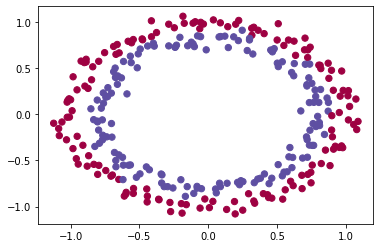

In [ ]:
# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

In [ ]:
# Neural Network Structure
layers_dims = [train_X.shape[0], 10, 5, 1]

Cost after iteration 0: 0.736849
Cost after iteration 10000: 0.204608
Cost after iteration 20000: 0.047494
There is a mistake in the backward propagation! difference = 0.8300830492551543
On the train set:  0.9966666666666668
On the test set:  0.94


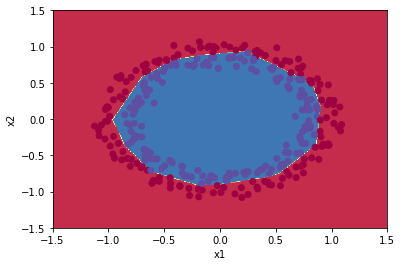

In [ ]:
parameters = model(train_X, train_Y, layers_dims, learning_rate=0.01, num_of_iterations=30000, print_cost=True, print_cost_after=10000)

predictions_train = predict_accuracy(train_X, train_Y, parameters, len(layers_dims) - 1)
print ("On the train set: ", predictions_train)
predictions_test = predict_accuracy(test_X, test_Y, parameters, len(layers_dims) - 1)
print ("On the test set: ", predictions_test)

axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T, len(layers_dims) - 1), train_X, train_Y)

There is a mistake in the backward propagation! difference = 0.9043266718492676
There is a mistake in the backward propagation! difference = 0.05405731566973563
There is a mistake in the backward propagation! difference = 1.572249191289446e-05
There is a mistake in the backward propagation! difference = 0.034376640912458525


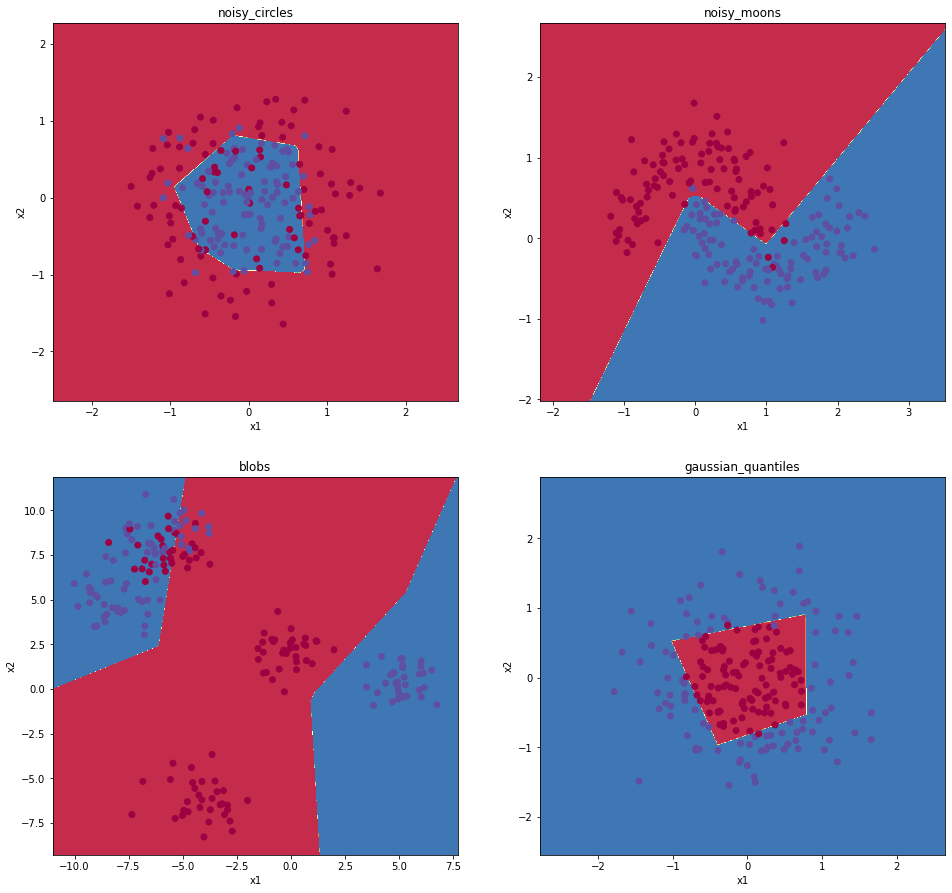

In [ ]:
# Using other datasets


# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {
    'noisy_circles': noisy_circles,
    'noisy_moons': noisy_moons,
    'blobs': blobs,
    'gaussian_quantiles': gaussian_quantiles
}

plt.figure(figsize=(16, 32))

layers_dims = [2, 5, 1]
for i, dataset in enumerate(datasets):
    plt.subplot(4, 2, i+1)
    plt.title(dataset)
    X, Y = datasets[dataset]
    X, Y = X.T, Y.reshape(1, Y.shape[0])
    
    # make blobs binary
    if dataset == "blobs":
        Y = Y%2
    
    # Build a model with a n_h-dimensional hidden layer
    parameters = model(X, Y, layers_dims, learning_rate=0.01, num_of_iterations=30000, print_cost=False, print_cost_after=10000)
    
    # Plot the decision boundary
    plot_decision_boundary(lambda x: predict(parameters, x.T, len(layers_dims) - 1), X, Y)

---